In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gc
import os, sys
import seaborn as sns
from tqdm import tqdm

from google.colab import files
import cv2

from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from google.colab.patches import cv2_imshow
from tensorflow.keras.layers import Conv2D,Flatten,MaxPool2D,BatchNormalization,GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model, Model

sns.set_style('darkgrid')

# Bước 2: Load ảnh

In [ ]:
datalink = '/content/drive/MyDrive/COURSES/CS116/VGG16-data/'
os.listdir(datalink)

['human', 'cat', 'tree', 'car', 'dog', 'output']

In [ ]:
df = {'file_name': [], 'label': []}
df = pd.DataFrame(df)
for lbl in os.listdir(datalink):
    for filename in os.listdir(datalink + lbl):
        new_row = {'file_name': datalink+lbl+'/'+filename, 'label': lbl}
        df = df.append(new_row, ignore_index=True)
df

,file_name,label
0,/content/drive/MyDrive/COURSES/CS116/VGG16-dat...,human
1,/content/drive/MyDrive/COURSES/CS116/VGG16-dat...,human
2,/content/drive/MyDrive/COURSES/CS116/VGG16-dat...,human
3,/content/drive/MyDrive/COURSES/CS116/VGG16-dat...,human
4,/content/drive/MyDrive/COURSES/CS116/VGG16-dat...,cat
5,/content/drive/MyDrive/COURSES/CS116/VGG16-dat...,cat
6,/content/drive/MyDrive/COURSES/CS116/VGG16-dat...,cat
7,/content/drive/MyDrive/COURSES/CS116/VGG16-dat...,cat
8,/content/drive/MyDrive/COURSES/CS116/VGG16-dat...,tree
9,/content/drive/MyDrive/COURSES/CS116/VGG16-dat...,tree


In [ ]:
batch_size = 32
img_height = 480
img_width = 480
target_size = (img_height, img_width)

In [ ]:
datagen = ImageDataGenerator()

# Bước 3: Tạo model và rút trích đặc trưng

In [ ]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [ ]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)

In [ ]:
cnt = 0
feature_map = []
for i in range(len(df)):
    cnt += 1
    # print(df['file_name'][i])
    img = image.load_img(df['file_name'][i], target_size=(224, 224, 3))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    image_feature = model.predict(x).ravel()
    feature_map.append(image_feature)
    print(image_feature.shape)

(100352,)
(100352,)
(100352,)
(100352,)
(100352,)
(100352,)
(100352,)
(100352,)
(100352,)
(100352,)
(100352,)
(100352,)
(100352,)
(100352,)
(100352,)
(100352,)
(100352,)
(100352,)
(100352,)
(100352,)


In [117]:
neigh = KNeighborsClassifier(n_neighbors=3, metric='cosine')
neigh.fit(feature_map, df['label'])

KNeighborsClassifier(metric='cosine', n_neighbors=3)

# Đọc ảnh truy vấn, trích xuất đặc trưng, và show top k ảnh gần nhất

['car']
----------------Original image---------------


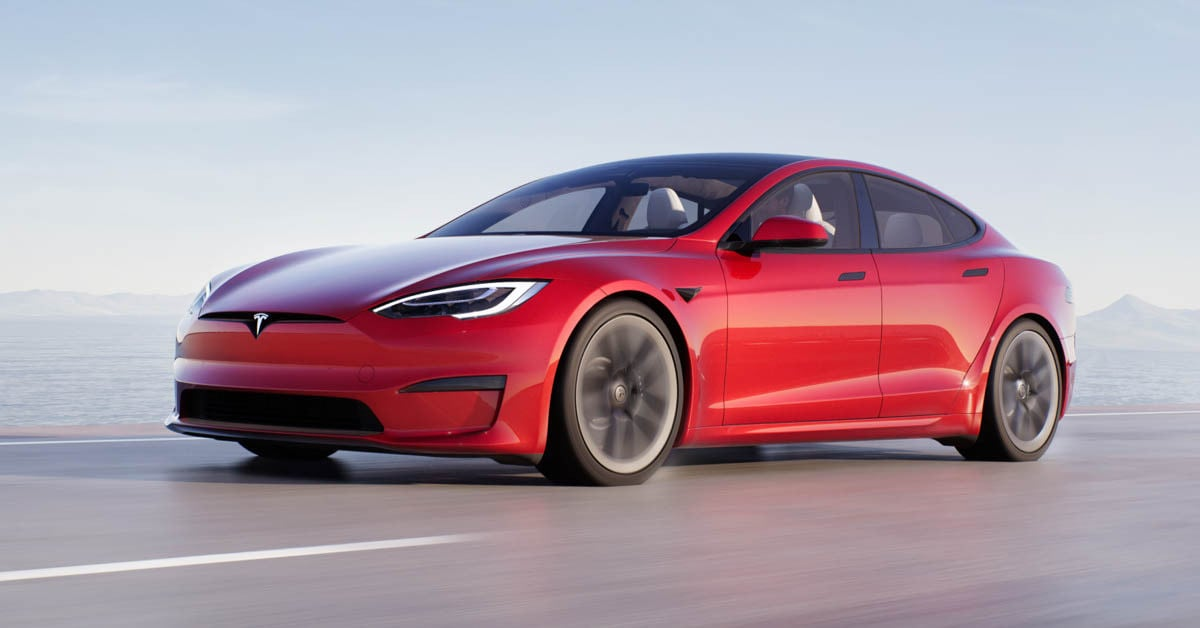



----------------TOP 3-----------------




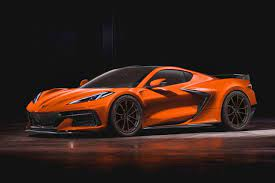

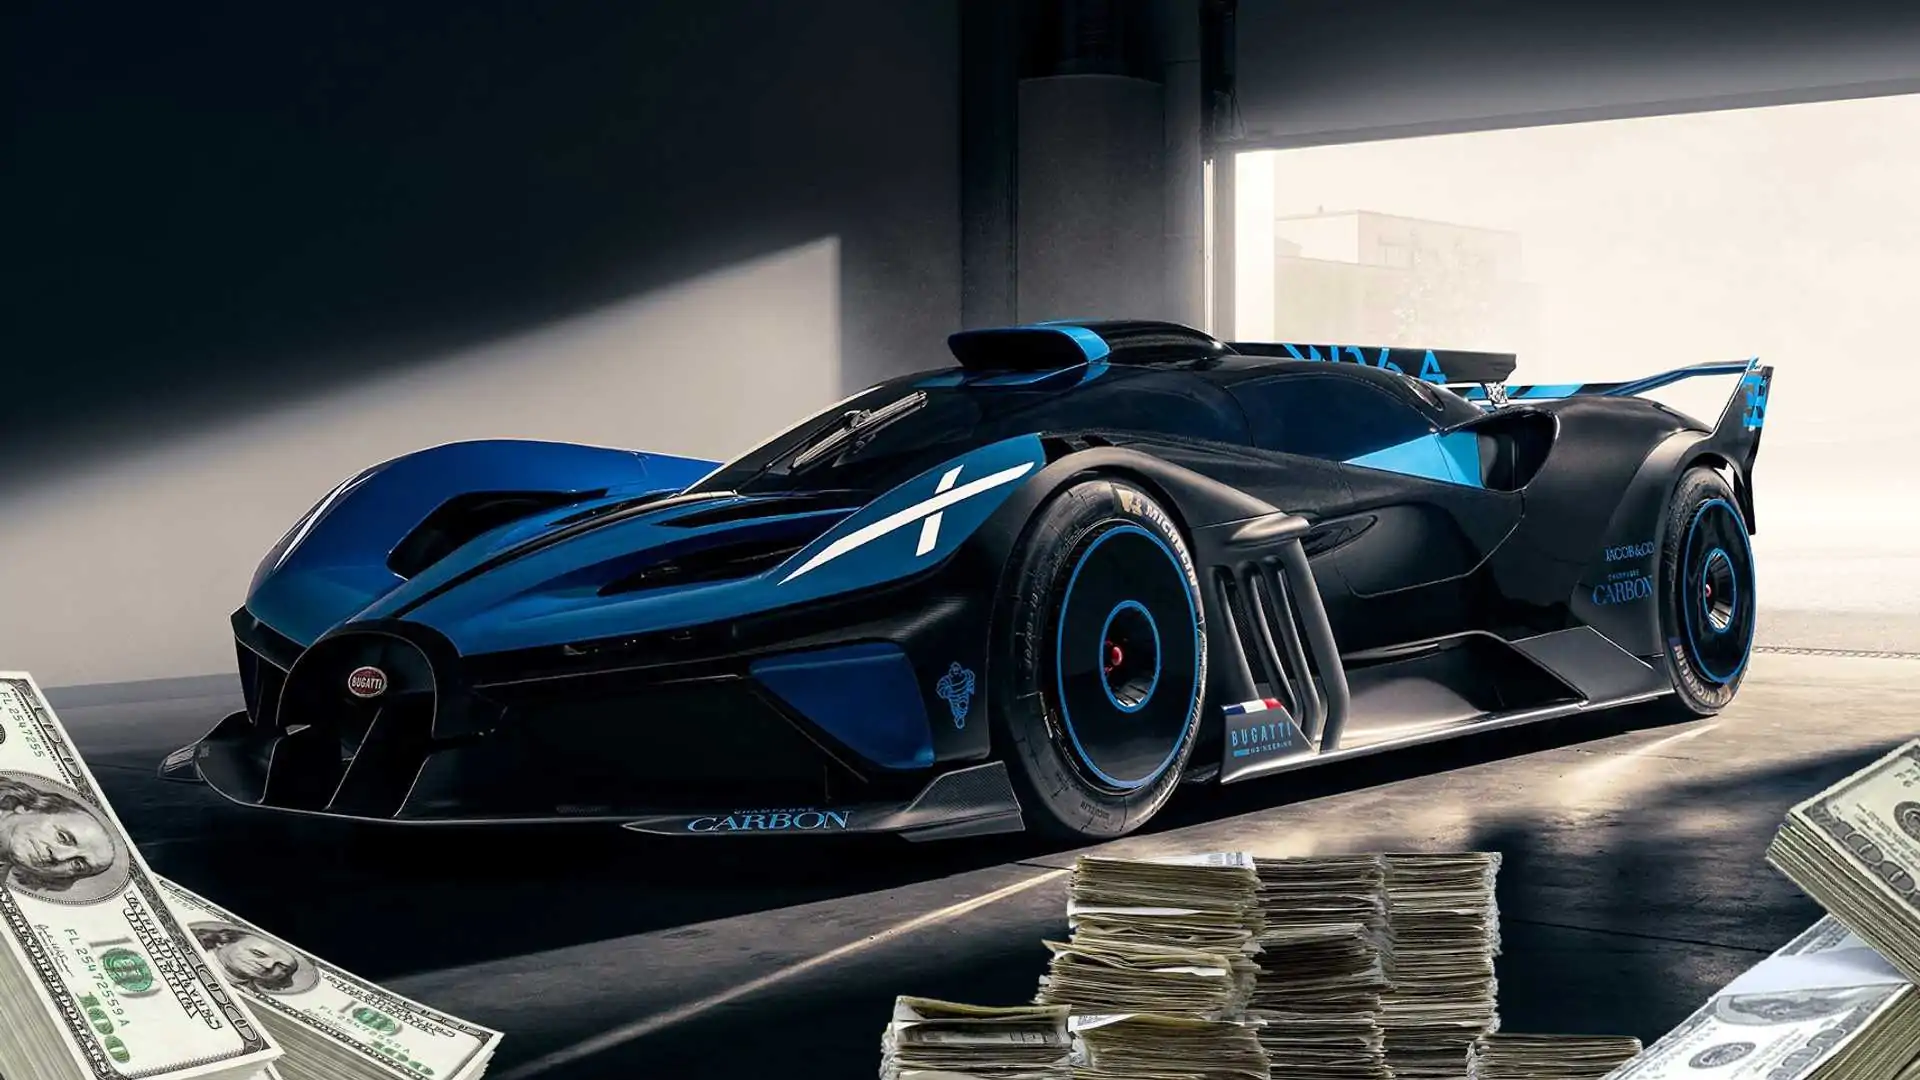

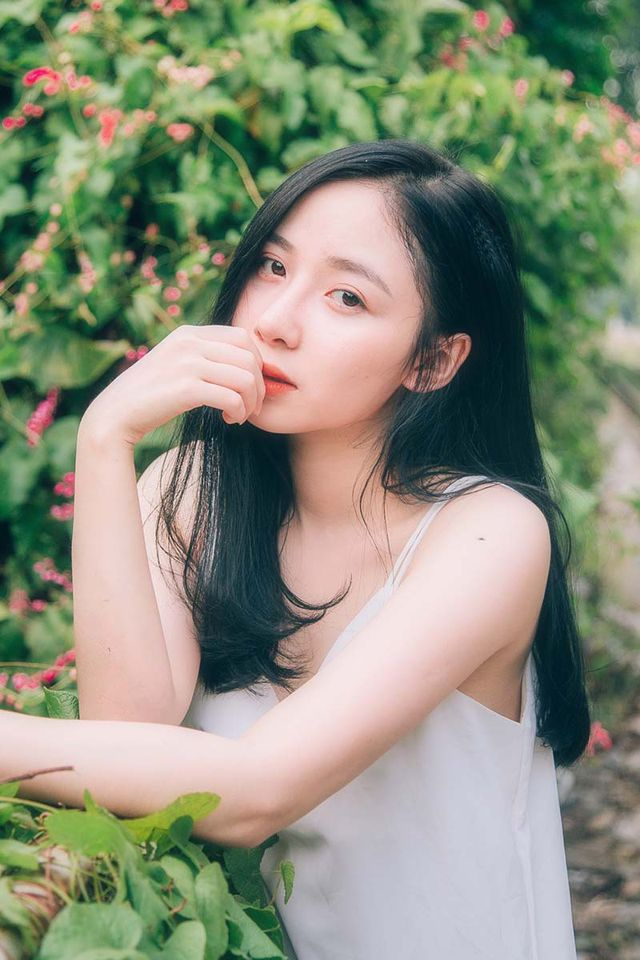

In [119]:
query_image = [datalink + 'query/' + _ for _ in os.listdir(datalink + 'query/')]
for query in query_image:
    img = image.load_img(query, target_size=(224, 224, 3))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    query_image_feature = model.predict(x).flatten().reshape(-1, 1).T
    print(neigh.predict(query_image_feature))
    print('----------------Original image---------------')
    cv2_imshow(cv2.imread(query))
    info = neigh.kneighbors(query_image_feature)
    print('\n\n----------------TOP 3-----------------\n\n')
    for i in range(3):
        index = info[1][0][i]
        cv2_imshow(cv2.imread(df['file_name'][index]))